In [22]:
pip install gensim

In [33]:
import pandas as pd

df = pd.read_csv("IMDB Dataset.csv")  # Load IMDB reviews
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})  # Convert to numeric

print(df[['sentiment', 'label']].head())

  sentiment  label
0  positive      1
1  positive      1
2  positive      1
3  negative      0
4  positive      1


In [34]:
print("Dataset shape:", df.shape)
print("Class distribution:\n", df['sentiment'].value_counts())

df['review_length'] = df['review'].apply(lambda x: len(x.split()))
print(df['review_length'].describe())

Dataset shape: (50000, 3)
Class distribution:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64
count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review_length, dtype: float64


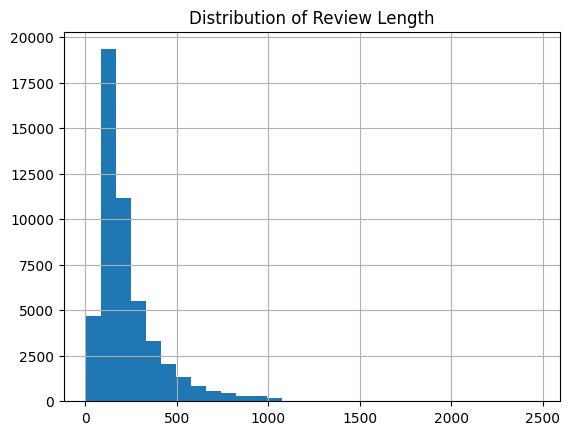

In [35]:
import matplotlib.pyplot as plt
df['review_length'].hist(bins=30)
plt.title("Distribution of Review Length")
plt.show()

In [36]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', ' ', text)  # remove HTML
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # remove special characters
    tokens = text.lower().split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

df['tokens'] = df['review'].apply(clean_text)
print(df['tokens'].head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


0    [one, reviewer, mentioned, watching, oz, episo...
1    [wonderful, little, production, filming, techn...
2    [thought, wonderful, way, spend, time, hot, su...
3    [basically, family, little, boy, jake, think, ...
4    [petter, mattei, love, time, money, visually, ...
Name: tokens, dtype: object


In [37]:
import numpy as np

def get_doc_vector(tokens, model):
    valid_words = [w for w in tokens if w in model]
    if valid_words:
        return np.mean([model[w] for w in valid_words], axis=0)
    else:
        return np.zeros(model.vector_size)

##Pretrained Word2Vec (Google News)

In [38]:
import gensim.downloader as api
pre_w2v = api.load("word2vec-google-news-300")
df['pre_w2v_vec'] = df['tokens'].apply(lambda x: get_doc_vector(x, pre_w2v))

In [39]:
from gensim.models import Word2Vec, FastText

# Custom Skip-gram
print("🧠 Training custom Skip-gram model...")
skipgram_model = Word2Vec(sentences=df['tokens'], vector_size=100, sg=1, window=5, min_count=2, workers=4).wv
df['skipgram_vec'] = df['tokens'].apply(lambda x: get_doc_vector(x, skipgram_model))

# Custom CBOW
print("🧠 Training custom CBOW model...")
cbow_model = Word2Vec(sentences=df['tokens'], vector_size=100, sg=0, window=5, min_count=2, workers=4).wv
df['cbow_vec'] = df['tokens'].apply(lambda x: get_doc_vector(x, cbow_model))

🧠 Training custom Skip-gram model...
🧠 Training custom CBOW model...


##FastText Model

In [40]:
fasttext_model = FastText(sentences=df['tokens'], vector_size=100, sg=1, window=5, min_count=2, workers=4).wv
df['fasttext_vec'] = df['tokens'].apply(lambda x: get_doc_vector(x, fasttext_model))

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

def train_and_evaluate(vec_column, model_name):
    X = np.vstack(df[vec_column].values)
    y = df['label'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n{model_name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))

    return model_name, acc


In [42]:
results = []
results.append(train_and_evaluate('pre_w2v_vec', 'Pretrained Word2Vec'))
results.append(train_and_evaluate('skipgram_vec', 'Custom Skipgram'))
results.append(train_and_evaluate('cbow_vec', 'Custom CBOW'))
results.append(train_and_evaluate('fasttext_vec', 'Custom FastText'))

# Tabulate results
import pandas as pd
result_df = pd.DataFrame(results, columns=["Model", "Accuracy"])
print("\n Final Accuracy Comparison:\n")
print(result_df)



Pretrained Word2Vec Accuracy: 0.8496
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4961
           1       0.85      0.85      0.85      5039

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000


Custom Skipgram Accuracy: 0.8730
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      4961
           1       0.87      0.88      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000


Custom CBOW Accuracy: 0.8606
              precision    recall  f1-score   support

           0       0.87      0.85      0.86      4961
           1       0.86      0.87      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86   